In [31]:
import pandas as pd

mutations = pd.read_csv('../analysis/merged_variants_anno_vaf_filtered.txt', sep="\t",
                        header=0, index_col=0, low_memory=False)
metasamples = pd.read_excel('../Metadata.xlsx')
metasamples['SAMPLE_ID'] = metasamples['SAMPLE_ID'].astype(str)
metasamples.index = [x.strip() for x in metasamples['SAMPLE_ID'] + '-' + metasamples['PATIENT_ID']]

In [32]:
# Keep only samples that are tumor-normal pair and labeled as included
meta_filtered = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                                & (metasamples['TUMOR_ONLY'] == "No")
                                & (metasamples['SAMPLE_TYPE'] != "gDNA")
                                & (metasamples['VAR3'].notnull()), :]
mutations_filtered = mutations.loc[:, mutations.columns[0:10].to_list() + meta_filtered.index.to_list()]

In [33]:
print('Total patients (BEFORE) {}'.format(len(set(meta_filtered[meta_filtered['VAR3'] == 'BEFORE']['PATIENT_ID']))))
print('Total samples (BEFORE) {}'.format(len(set(meta_filtered[meta_filtered['VAR3'] == 'BEFORE']['SAMPLE_ID']))))

print('Total patients (AFTER) {}'.format(len(set(meta_filtered[meta_filtered['VAR3'] == 'AFTER']['PATIENT_ID']))))
print('Total samples (AFTER) {}'.format(len(set(meta_filtered[meta_filtered['VAR3'] == 'AFTER']['SAMPLE_ID']))))

Total patients (BEFORE) 4
Total samples (BEFORE) 8
Total patients (AFTER) 4
Total samples (AFTER) 4


In [34]:
from collections import defaultdict

VAF_FILTER = 5.0
NUM_PATIENTS_FILTER = 1

mutations_seen_only_BEFORE = list()
mutations_seen_only_AFTER = list()
mutations_seen_BEFORE = defaultdict(list)
mutations_seen_AFTER = defaultdict(list)

SAMPLES_BEFORE = meta_filtered[meta_filtered['VAR3'] == 'BEFORE'].index.to_list()
SAMPLES_AFTER = meta_filtered[meta_filtered['VAR3'] == 'AFTER'].index.to_list()

for index, row in mutations_filtered.iterrows():
    samples_before = list()
    samples_after = list()
    gene = row['GENE']
    acc_vaf_BEFORE = 0
    acc_vaf_AFTER = 0
    
    for column, value in row[10:].items():
        if float(value) >= VAF_FILTER:
            if column in SAMPLES_BEFORE:
                acc_vaf_BEFORE += float(value)
                samples_before.append(column)
            if column in SAMPLES_AFTER:
                acc_vaf_AFTER += float(value)
                samples_after.append(column)

    if len(samples_before) > 0:
        patients = set([x.split('-')[-1] for x in samples_before])
        for g in gene.split('|'):
            mutations_seen_BEFORE[g].append((index, acc_vaf_BEFORE, samples_before, patients))
            
    if len(samples_after) > 0:
        patients = set([x.split('-')[-1] for x in samples_after])
        for g in gene.split('|'):
            mutations_seen_AFTER[g].append((index, acc_vaf_AFTER, samples_after, patients))
            
    if len(samples_before) > 0 and len(samples_after) == 0:
        patients = set([x.split('-')[-1] for x in samples_before])
        if len(patients) >= NUM_PATIENTS_FILTER:
            mutations_seen_only_BEFORE.append((index, gene, samples_before, len(samples_before), len(patients)))
            
    if len(samples_before) == 0 and len(samples_after) > 0:
        patients = set([x.split('-')[-1] for x in samples_after])
        if len(patients) >= NUM_PATIENTS_FILTER:
            mutations_seen_only_AFTER.append((index, gene, samples_after, len(samples_after), len(patients)))

In [35]:
import numpy as np

with open('../analysis/analysis_before_after/BEFORE/genes_table.txt', 'w') as f:
    f.write('GENE\tCUM_VAF\tNUM_MUTATIONS\tMUTATIONS\tNUM_SAMPLES\tSAMPLES\tNUM_PATIENTS\tPATIENTS\n')
    for gene, records in mutations_seen_BEFORE.items():
        acc_vaf = 0
        patients = set()
        samples = set()
        mutations = set()
        for mut in records:
            acc_vaf += mut[1]
            mutations.add(mut[0])
            samples.update(mut[2])
            patients.update(mut[3])
        f.write('\t'.join([gene,
                           str(np.round(acc_vaf, 2)),
                           str(len(mutations)), 
                           ';'.join(mutations), 
                           str(len(samples)), 
                           ';'.join(samples),
                           str(len(patients)),
                           ';'.join(patients)]) + '\n')

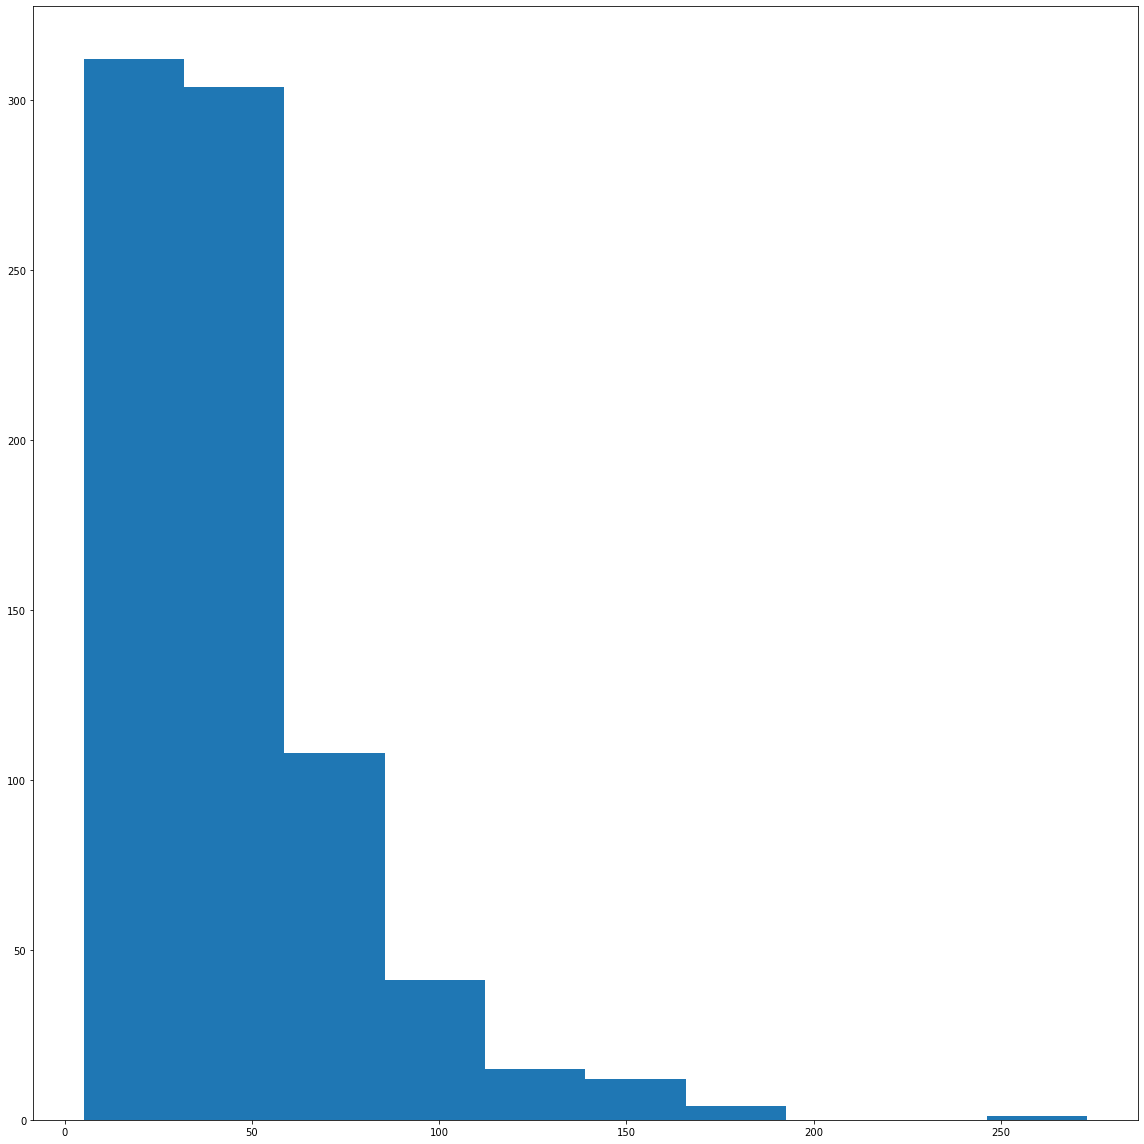

In [36]:
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

records = [y for x in mutations_seen_BEFORE.values() for y in x]
cum_vaf_values = [x[1] for x in records]
mutations_per_patient = Counter([y for x in records for y in x[3]])
mutations_per_sample = Counter([y.split('-')[0] for x in records for y in x[2]])

fig, ax = plt.subplots(figsize=(16,16))
ax.hist(cum_vaf_values, bins=10, density=False)
fig.tight_layout()
fig.savefig('../analysis/analysis_before_after/BEFORE/cum_vaf_dist.png')

In [37]:
with open('../analysis/analysis_before_after/AFTER/genes_table.txt', 'w') as f:
    f.write('GENE\tCUM_VAF\tNUM_MUTATIONS\tMUTATIONS\tNUM_SAMPLES\tSAMPLES\tNUM_PATIENTS\tPATIENTS\n')
    for gene, records in mutations_seen_AFTER.items():
        acc_vaf = 0
        patients = set()
        samples = set()
        mutations = set()
        for mut in records:
            acc_vaf += mut[1]
            mutations.add(mut[0])
            samples.update(mut[2])
            patients.update(mut[3])
        f.write('\t'.join([gene,
                           str(np.round(acc_vaf, 2)),
                           str(len(mutations)), 
                           ';'.join(mutations), 
                           str(len(samples)), 
                           ';'.join(samples),
                           str(len(patients)),
                           ';'.join(patients)]) + '\n')

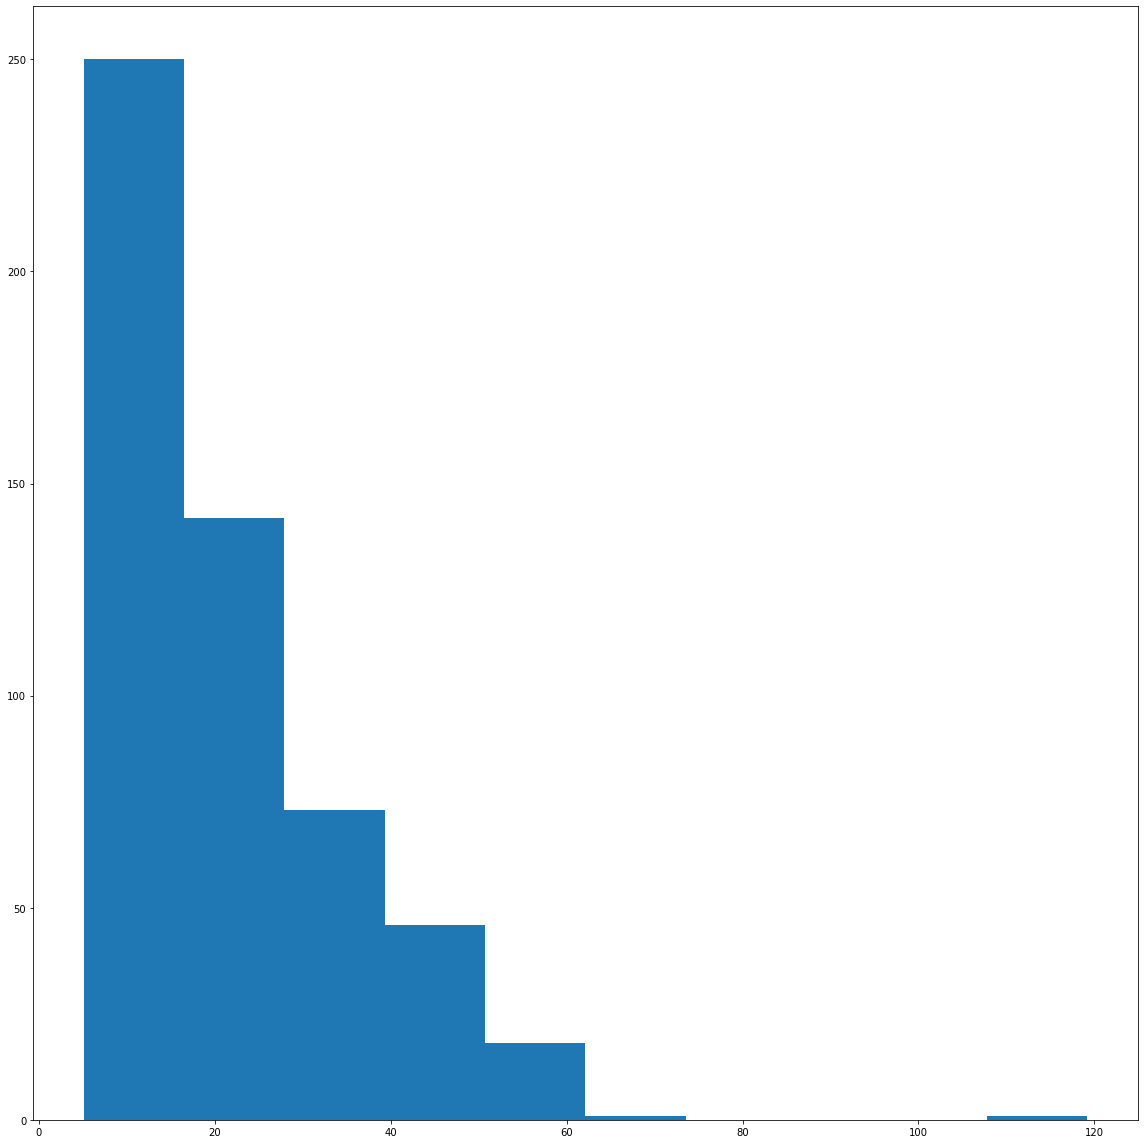

In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

records = [y for x in mutations_seen_AFTER.values() for y in x]
cum_vaf_values = [x[1] for x in records]
mutations_per_patient = Counter([y for x in records for y in x[3]])
mutations_per_sample = Counter([y.split('-')[0] for x in records for y in x[2]])

fig, ax = plt.subplots(figsize=(16,16))
ax.hist(cum_vaf_values, bins=10, density=False)
fig.tight_layout()
fig.savefig('../analysis/analysis_before_after/AFTER/cum_vaf_dist.png')

In [39]:
import gseapy as gp
import matplotlib.pyplot as plt

#genes = [x[1] for x in mutations_seen_only_BEFORE]
#enr = gp.enrichr(gene_list = genes,
#                 gene_sets = ['KEGG_2019_Human','GO_Biological_Process_2018', 'GO_Molecular_Function_2018'],
#                 organism = 'Human',
#                 description = 'Group BEFORE',
#                 outdir = '../analysis/analysis_before_after/BEFORE',
#                 # no_plot=True,
#                 cutoff = 1.0)

mutations_BEFORE = mutations_filtered.loc[[x[0] for x in mutations_seen_only_BEFORE], :]
mutations_BEFORE.insert(10, 'SAMPLES', [';'.join(x[2]) for x in mutations_seen_only_BEFORE])
mutations_BEFORE.insert(11, 'NUM_SAMPLES', [x[3] for x in mutations_seen_only_BEFORE])
mutations_BEFORE.insert(12, 'NUM_PATIENTS', [x[4] for x in mutations_seen_only_BEFORE])
mutations_BEFORE.to_csv('../analysis/analysis_before_after/BEFORE/mutations_table.txt', sep="\t", header=True)

In [40]:
genes = [x[1] for x in mutations_seen_only_AFTER]

#enr = gp.enrichr(gene_list = genes,
#                 gene_sets = ['KEGG_2019_Human','GO_Biological_Process_2018', 'GO_Molecular_Function_2018'],
#                 organism = 'Human',
#                 description = 'Group AFTER',
#                 outdir = 'analysis_before_after/AFTER',
#                 # no_plot=True,
#                 cutoff = 1.0)

mutations_AFTER = mutations_filtered.loc[[x[0] for x in mutations_seen_only_AFTER], :]
mutations_AFTER.insert(10, 'SAMPLES', [';'.join(x[2]) for x in mutations_seen_only_AFTER])
mutations_AFTER.insert(11, 'NUM_SAMPLES', [x[3] for x in mutations_seen_only_AFTER])
mutations_AFTER.insert(12, 'NUM_PATIENTS', [x[4] for x in mutations_seen_only_AFTER])
mutations_AFTER.to_csv('../analysis/analysis_before_after/AFTER/mutations_table.txt', sep="\t", header=True)